In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,roc_auc_score,ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# UnderSampling Techniques
from imblearn.under_sampling import RandomUnderSampler

# SMOTE Techinique
from imblearn.over_sampling import SMOTE

In [2]:
datasets=["datasets/cnn_reduced_50+pylidc_features_nl.csv",
          "datasets/cnn_reduced_50+pylidc_features_nl2.csv",
          "datasets/cnn_reduced_50+pylidc_features_nl4.csv",
          "datasets/cnn_reduced_50+pylidc_features.csv"]
df=[pd.read_csv(dataset) for dataset in datasets]

In [3]:
df1=df[2]
df1.head(5)


,PatientID,Calcification,Lobulation,Spiculation,Internal Texture,Diameter (mm),Surface Area (mm^2),Volume (mm^3),Pixeis_in_lesion,Circularity,...,cnn_feature 41,cnn_feature 42,cnn_feature 43,cnn_feature 44,cnn_feature 45,cnn_feature 46,cnn_feature 47,cnn_feature 48,cnn_feature 49,Label
0,LIDC-IDRI-0001,6,3,4,5,32.755812,2491.466573,6989.673615,5428,0.121212,...,7.040247,-1.513496,0.775723,-0.234806,-5.807555,-3.458864,-4.258366,4.971976,-1.937084,5
1,LIDC-IDRI-0002,6,1,1,2,30.781671,2807.198994,7244.667508,14252,0.243756,...,3.515642,5.453791,-4.427953,-4.131188,-2.238985,-0.942886,-7.291642,7.063912,4.522726,5
2,LIDC-IDRI-0003,6,1,1,1,31.664468,1996.252117,4731.410934,2542,0.154584,...,5.648545,-5.778849,-2.962466,6.492604,-3.243713,-0.093044,-7.528972,1.491716,-5.227047,1
3,LIDC-IDRI-0003,6,2,3,4,31.001964,2225.677350,6519.463698,3241,0.139765,...,-0.395001,-0.695193,-0.807704,1.977416,-2.345557,-1.399320,-3.947806,9.112702,-2.307368,5
4,LIDC-IDRI-0003,6,2,2,5,13.309155,321.183599,472.089669,261,0.271896,...,-1.828549,-1.749191,-3.188446,-0.763180,0.101668,-0.589906,1.837360,-0.556560,-2.447910,1


This code splits df1 into training and test sets based on unique patient IDs, using an 80-20 split with a fixed random state for reproducibility.

In [4]:
#to keep the nodules from the same patient in the same group either train or test, we do this:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 42)
split = splitter.split(df1, groups=df1['PatientID'])
train_inds, test_inds = next(split)

train = df1.iloc[train_inds]
test = df1.iloc[test_inds]

In [5]:
#seperate the class from the features and drop index
testy=test["Label"]
testx=test.drop(["Label","PatientID"],axis=1)
testx=testx.reset_index(drop=True)
trainy=train["Label"]
trainx=train.drop(["Label","PatientID"],axis=1)
trainx=trainx.reset_index(drop=True)

In the code bellow we aplpy random undersampling in order to achive a balanced class distriuition. The reason behind this is because in all of the datasets even with the diferent labels (especialy the one that have the class 2 and 3 separated) there is an clear discrepancy between classes in terms of their distribuition. This method is going to have reasonable results in labels which the least dominant class sill has a good ammount of cases

In [6]:
# IMPORTANT: ONLY RUN THIS PART OF THE CODE IF YOU WANT UNDERSAMPLING IN YOUR TRAINNIG DATA
#
print("Original class distribution:\n",trainy.value_counts())

undersample= RandomUnderSampler(random_state=42)
trainx,trainy= undersample.fit_resample(trainx,trainy)

print("\nUnderSamlped class distribuition:\n",trainy.value_counts())

Original class distribution:
 Label
1    1702
5     409
Name: count, dtype: int64

UnderSamlped class distribuition:
 Label
1    409
5    409
Name: count, dtype: int64


The reasoning behind appying SMOTE is similar to that of the undersampling, however it tends to work better since it doens't make trainning data smaller

In [6]:
# IMPORTANT ONLY RUN THIS PART OF THE CODE IF YOU WANT SMOTE IN YOUR TRAINNING DATA
#
print("Original class distribution:\n",trainy.value_counts())

smote=SMOTE(random_state=42)
trainx, trainy=smote.fit_resample(trainx,trainy)

print("\nSMOTE class distribution:",trainy.value_counts())

Original class distribution:
 Label
1    1702
5     409
Name: count, dtype: int64

SMOTE class distribution: Label
5    1702
1    1702
Name: count, dtype: int64


In [7]:
trainy.head(5)

0    5
1    5
2    1
3    5
4    1
Name: Label, dtype: int64

In this part of the code, we not only used cross-validation to tune the parameters, with the restriction of n_estimators (number of trees) being 1000, but also used a random search to find the best hyperparameters before fitting the search object to our data.

In [8]:
#Using CV to tune the parameters but with the n_estimators fixed at 1000

param_dist = {'max_depth': randint(5,50),
              'min_samples_split': randint(2,10)}

rf = RandomForestClassifier(n_estimators=1000,random_state=42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=42)

# Fit the random search object to the data
rand_search.fit(trainx, trainy)
print("Best parameters:", rand_search.best_params_)
print("Best cross_validation_score:", rand_search.best_score_)

Best parameters: {'max_depth': 18, 'min_samples_split': 3}
Best cross_validation_score: 0.9151045175779563


In [9]:
rft = RandomForestClassifier(n_estimators=1000, max_depth=18, min_samples_split=3,random_state=42) 
rft.fit(trainx, trainy)

RandomForestClassifier(max_depth=18, min_samples_split=3, n_estimators=1000,
                       random_state=42)

In this code cell, we used a Random Forest option to calculate the importance of each feature in the dataset to understand which features were most important for our results.

In [10]:
#Get the features names
feature_names = [col for col in df1.columns if col not in ["Label", "PatientID"]]

#Gives us the most important attributes to the RandomForest classifier
feature_importances = rft.feature_importances_

# Combine feature names with their importance values
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df.head(51)


,Feature,Importance
0,Pixeis_in_lesion,0.119011
1,Surface Area (mm^2),0.102600
2,Volume (mm^3),0.095141
3,Diameter (mm),0.087774
4,Circularity,0.048173
5,cnn_feature 3,0.027415
6,cnn_feature 0,0.023880
7,Spiculation,0.018844
8,VAR_HU_in_lession,0.017916
9,Median_HU_in_lesion,0.017426


Here, we have the accuracy, recall, and precision scores of our model when using two values for the specified column label.

In [21]:
predy=rft.predict(testx)
pred_proba=rft.predict_proba(testx)
print(roc_auc_score(testy,pred_proba[:,-1]))
print(accuracy_score(testy,predy))
print(recall_score(testy,predy,average="macro"))
print(precision_score(testy,predy,average="weighted"))
print(classification_report(testy,predy))

0.9283536585365854
0.9085603112840467
0.8714995483288166
0.9180554312521871
              precision    recall  f1-score   support

           1       0.96      0.93      0.94       432
           5       0.68      0.82      0.74        82

    accuracy                           0.91       514
   macro avg       0.82      0.87      0.84       514
weighted avg       0.92      0.91      0.91       514



In [22]:
np.unique(trainy)
#1 significa benigno, 3 incerto, 5 maligno

array([1, 5])

Here, we created a confusion matrix to see the exact number of cases correctly and incorrectly predicted by the model by comparing the predicted labels to the actual labels.

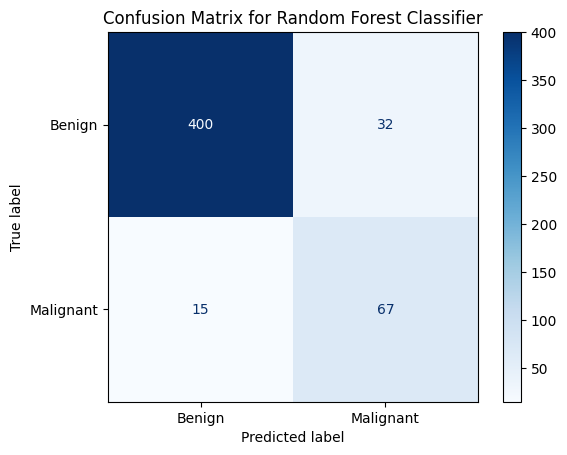

In [23]:
import matplotlib.pyplot as plt
cm = confusion_matrix(testy, predy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Malignant"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [24]:
df2=df[0]
df3=df[1]
df4=df[3]

This code splits df4 into training and test sets based on unique patient IDs, using an 80-20 split with a fixed random state for reproducibility.

In [25]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 42)
split = splitter.split(df4, groups=df4['PatientID'])
train_inds, test_inds = next(split)
train = df4.iloc[train_inds]
test = df4.iloc[test_inds]

In [26]:
testy2=test["Label"]
testx2=test.drop(["Label","PatientID"],axis=1)
testx2=testx2.reset_index(drop=True)
trainy2=train["Label"]
trainx2=train.drop(["Label","PatientID"],axis=1)
trainx2=trainx2.reset_index(drop=True)

Since SMOTE worked best we are gonna use it in the other datasets

In [27]:
# IMPORTANT ONLY RUN THIS PART OF THE CODE IF YOU WANT SMOTE IN YOUR TRAINNING DATA
#
print("Original class distribution:\n",trainy2.value_counts())

smote=SMOTE(random_state=42)
trainx2, trainy2=smote.fit_resample(trainx2,trainy2)

print("\nSMOTE class distribution:",trainy2.value_counts())

Original class distribution:
 Label
3    831
2    646
4    357
1    225
5     52
Name: count, dtype: int64

SMOTE class distribution: Label
5    831
4    831
2    831
3    831
1    831
Name: count, dtype: int64


In [28]:
trainy2.head(5)

0    5
1    4
2    2
3    4
4    3
Name: Label, dtype: int64

In [29]:
#Using CV to tune the parameters but with the n_estimators fixed at 1000

param_dist = {'max_depth': randint(5,50),
              'min_samples_split': randint(2,10)}

rf = RandomForestClassifier(n_estimators=1000,random_state=42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=42)

# Fit the random search object to the data
rand_search.fit(trainx2, trainy2)
print("Best parameters:", rand_search.best_params_)
print("Best cross_validation_score:", rand_search.best_score_)

Best parameters: {'max_depth': 48, 'min_samples_split': 2}
Best cross_validation_score: 0.7814681107099879


In [30]:
rft2 = RandomForestClassifier(n_estimators=1000, max_depth=48, min_samples_split=2,random_state=42) 
rft2.fit(trainx2, trainy2)

RandomForestClassifier(max_depth=48, n_estimators=1000, random_state=42)

Here, we have the accuracy, recall, and precision scores of our model when using five values for the specified column label.

In [32]:
predy2=rft2.predict(testx2)
pred_proba2=rft2.predict_proba(testx2)
print(roc_auc_score(testy2,pred_proba2,multi_class='ovr',average='macro'))
print(accuracy_score(testy2,predy2))
print(recall_score(testy2,predy2,average="macro"))
print(precision_score(testy2,predy2,average="weighted"))
print(classification_report(testy2,predy2))

0.8339255975301978
0.5214007782101168
0.5588397258188358
0.5267972947934038
              precision    recall  f1-score   support

           1       0.86      0.79      0.82        61
           2       0.50      0.41      0.45       184
           3       0.46      0.49      0.48       187
           4       0.48      0.72      0.57        64
           5       0.50      0.39      0.44        18

    accuracy                           0.52       514
   macro avg       0.56      0.56      0.55       514
weighted avg       0.53      0.52      0.52       514



Here, we created another confusion matrix, this time for data with five values for the label, to see where our model was more or less accurate in its predictions.
1 is benign, 2 likely benign, 3 uncertain, 4 likely malignant and 5 malignant

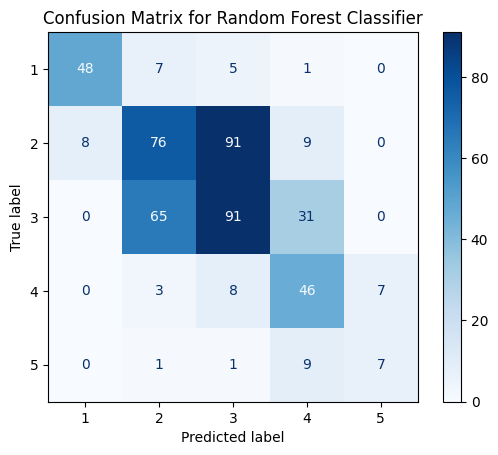

In [33]:
cm = confusion_matrix(testy2, predy2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1","2","3","4","5"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

Now we are gonna perfom the same but for df2 wich contains three values, Benign, Uncertain and Malignant.
We are not gonna use df3 because it doesn't serve any purpose to analyse

In [34]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 42)
split = splitter.split(df2, groups=df2['PatientID'])
train_inds, test_inds = next(split)
train = df2.iloc[train_inds]
test = df2.iloc[test_inds]

In [35]:
testy3=test["Label"]
testx3=test.drop(["Label","PatientID"],axis=1)
testx3=testx3.reset_index(drop=True)
trainy3=train["Label"]
trainx3=train.drop(["Label","PatientID"],axis=1)
trainx3=trainx3.reset_index(drop=True)

In [36]:
# IMPORTANT ONLY RUN THIS PART OF THE CODE IF YOU WANT SMOTE IN YOUR TRAINNING DATA
#
print("Original class distribution:\n",trainy3.value_counts())

smote=SMOTE(random_state=42)
trainx3, trainy3=smote.fit_resample(trainx3,trainy3)

print("\nSMOTE class distribution:",trainy3.value_counts())

Original class distribution:
 Label
1    871
3    831
5    409
Name: count, dtype: int64

SMOTE class distribution: Label
5    871
1    871
3    871
Name: count, dtype: int64


In [37]:
#Using CV to tune the parameters but with the n_estimators fixed at 1000

param_dist = {'max_depth': randint(5,50),
              'min_samples_split': randint(2,10)}

rf = RandomForestClassifier(n_estimators=1000,random_state=42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=42)

# Fit the random search object to the data
rand_search.fit(trainx3, trainy3)
print("Best parameters:", rand_search.best_params_)
print("Best cross_validation_score:", rand_search.best_score_)

Best parameters: {'max_depth': 18, 'min_samples_split': 3}
Best cross_validation_score: 0.663596404474627


In [38]:
rft3 = RandomForestClassifier(n_estimators=1000, max_depth=18, min_samples_split=3,random_state=42) 
rft3.fit(trainx3, trainy3)

RandomForestClassifier(max_depth=18, min_samples_split=3, n_estimators=1000,
                       random_state=42)

Scores

In [39]:
predy3=rft3.predict(testx3)
pred_proba3=rft3.predict_proba(testx3)
print(roc_auc_score(testy3,pred_proba3,multi_class='ovr',average='macro'))
print(accuracy_score(testy3,predy3))
print(recall_score(testy3,predy3,average="macro"))
print(precision_score(testy3,predy3,average="weighted"))
print(classification_report(testy3,predy3))

0.7952418137039468
0.5894941634241245
0.6358942690158104
0.6091737958552714
              precision    recall  f1-score   support

           1       0.70      0.53      0.60       245
           3       0.47      0.57      0.52       187
           5       0.66      0.80      0.73        82

    accuracy                           0.59       514
   macro avg       0.61      0.64      0.61       514
weighted avg       0.61      0.59      0.59       514



Confusion Matrix for 3 values

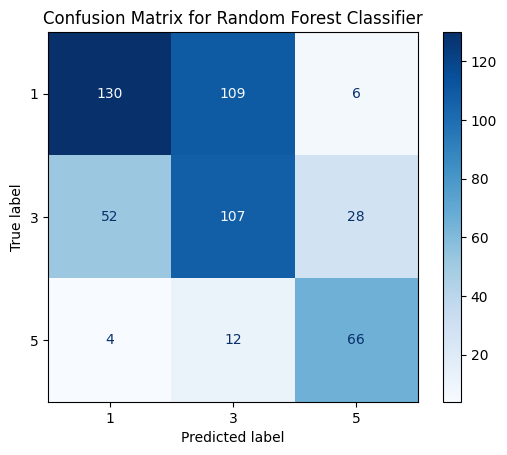

In [40]:
cm = confusion_matrix(testy3, predy3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1","3","5"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

To draw final conclusions, we created a simple bar graph showing the accuracy, recall, and precision values for all the datasets. This visualization helped us compare the model’s performance across different label configurations and assess its differences.

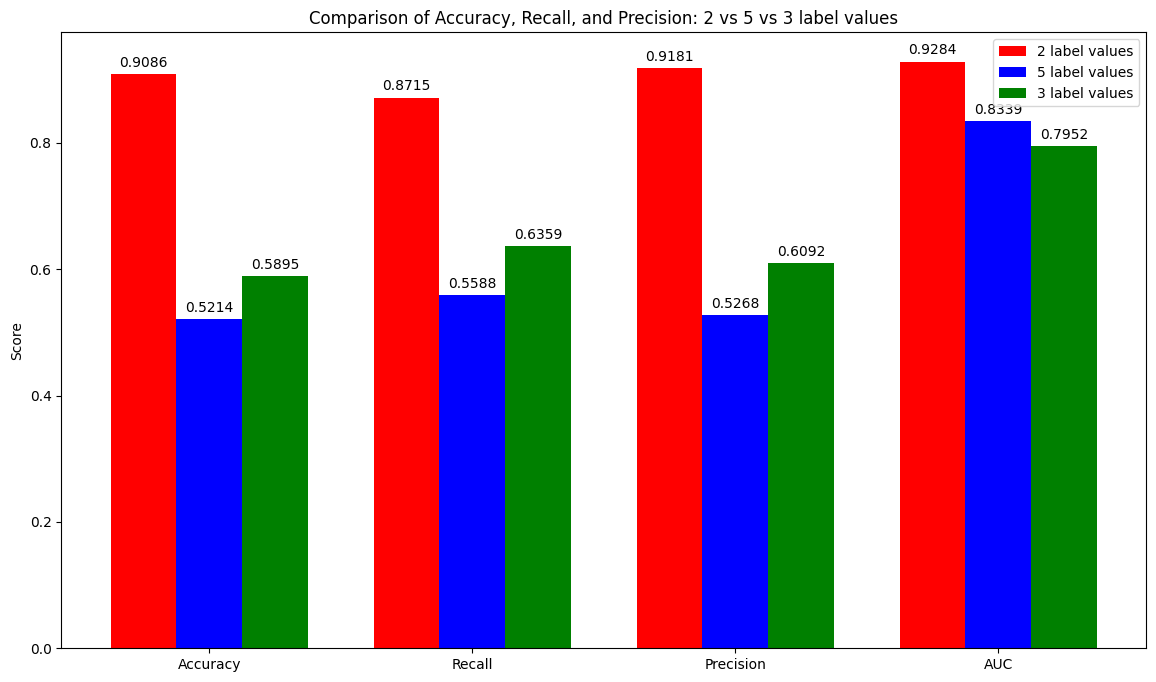

In [41]:
# Define labels for metrics
labels = ['Accuracy', 'Recall', 'Precision','AUC']

# Calculate scores for each model
two_scores = [
    accuracy_score(testy, predy),
    recall_score(testy, predy, average="macro"),
    precision_score(testy, predy, average="weighted"),
    roc_auc_score(testy,pred_proba[:,-1])
]
five_scores = [
    accuracy_score(testy2, predy2),
    recall_score(testy2, predy2, average="macro"),
    precision_score(testy2, predy2, average="weighted"),
    roc_auc_score(testy2,pred_proba2,multi_class='ovr',average='macro')
]
three_scores = [
    accuracy_score(testy3, predy3),
    recall_score(testy3, predy3, average="macro"),
    precision_score(testy3, predy3, average="weighted"),
    roc_auc_score(testy3,pred_proba3,multi_class='ovr',average='macro')
]

# Setup for bar plot
x = np.arange(len(labels))
width = 0.25  # Adjust width for three groups

# Increase figure size for readability
fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, two_scores, width, label='2 label values', color="red")
rects2 = ax.bar(x, five_scores, width, label='5 label values', color="blue")
rects3 = ax.bar(x + width, three_scores, width, label='3 label values', color="green")

# Labeling and legend
ax.set_ylabel('Score')
ax.set_title('Comparison of Accuracy, Recall, and Precision: 2 vs 5 vs 3 label values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display score values above bars
for rect in rects1 + rects2 + rects3:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Show plot
plt.show()

